# K-means CLustering

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from DataMatrix import generate_data_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import pairwise_distances
import math as m
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)


## Generating Data Matrix

### Mean Method

In [2]:
X_train, y_train, X_test, y_test = generate_data_matrix()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
y_test=y_test.astype(int)

(7296, 45)
(7296,)
(1824, 45)
(1824,)


### Flattening Method

In [3]:
X_train_flatten, y_train_flatten, X_test_flatten, y_test_flatten = generate_data_matrix("flatten")
print(X_train_flatten.shape)
print(y_train_flatten.shape)
print(X_test_flatten.shape)
print(y_test_flatten.shape)

(7296, 870)
(7296,)
(1824, 870)
(1824,)


## Helper Methods

In [37]:
def eucldiean_dist(X,Y):
    return np.linalg.norm(X-Y)
def calculate_wcss(indices,centroid,train_set):
    wcss=0
    for index in indices:
        wcss+=m.pow(eucldiean_dist(train_set[index],centroid),2)
    return wcss



## K-means Implementation

In [69]:
def kmeans(k, current_centroids, train_set):
    for _ in range(1000): 
        old_centroids = np.copy(current_centroids)
        distances = euclidean_distances(train_set, current_centroids)
        labels = np.argmin(distances, axis=1)+1
        current_centroids = np.array([np.mean(train_set[labels == i], axis=0) for i in range(1, k+1)])
        
        # Check for convergence
        if np.allclose(old_centroids, current_centroids):
            break
    
    return labels, current_centroids  

## Taking the best of 20 random starts

In [88]:
def BestRandomStart(train_set,k):
    Best_labels=np.zeros(train_set.shape[0])
    Best_centroids=np.zeros((k,train_set.shape[1]))
    min_wcss=float('inf')
    for _ in range(20):       
        initial_centroids = train_set[np.random.choice(train_set.shape[0], k, replace=False)]
        labels,centroids=kmeans(k,initial_centroids,train_set)
        lists = [[] for _ in range(k)]
        for i in range(len(labels)):
            lists[labels[i]-1].append(i)
        WCCS=0    
        for j in range(len(lists)):
            WCCS+=calculate_wcss(lists[j],centroids[j],train_set)
        if WCCS<min_wcss:
            min_wcss=WCCS
            Best_labels=labels
            Best_centroids=centroids
    return Best_labels,Best_centroids            

## Choosing The Best K By Taking The ELbow Point

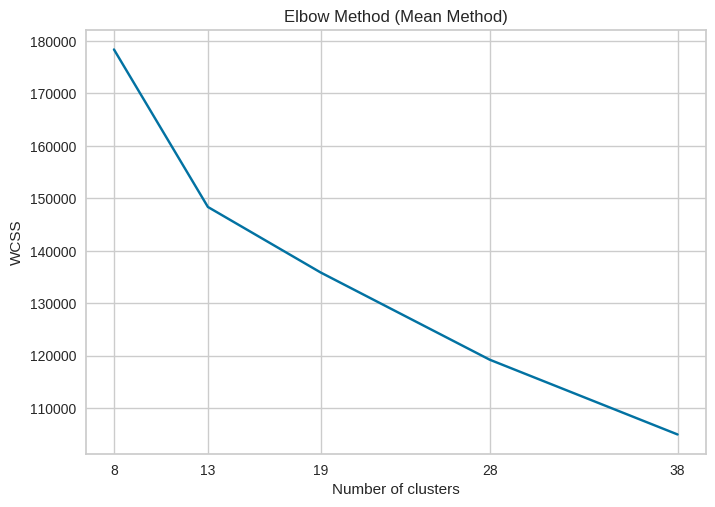

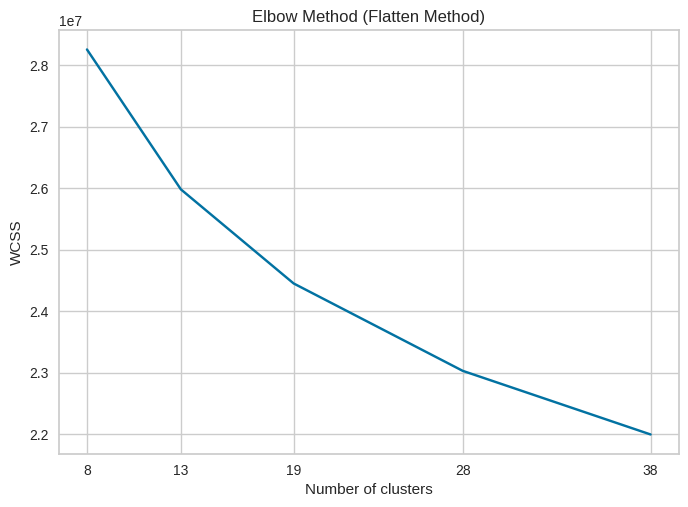

In [89]:
k_s=[8,13,19,28,38]
def elbow(train_set):
    results=[]
    for k in k_s:
        initial_centroids = train_set[np.random.choice(train_set.shape[0], k, replace=False)]
        labels,centroids=kmeans(k,initial_centroids,train_set)
        lists = [[] for _ in range(k)]
        for i in range(len(labels)):
            lists[labels[i]-1].append(i)
        WCCS=0    
        for j in range(len(lists)):
            WCCS+=calculate_wcss(lists[j],centroids[j],train_set)
        results.append([k,WCCS])
    return results
mean_results=pd.DataFrame(elbow(X_train),columns=['k','WCCS'])
flatten_results=pd.DataFrame(elbow(X_train_flatten),columns=['k','WCCS'])
plt.plot(mean_results['k'],mean_results['WCCS'])
plt.xlabel('Number of clusters')
plt.xticks(k_s)
plt.ylabel('WCSS')
plt.title('Elbow Method (Mean Method)')
plt.show()
plt.plot(flatten_results['k'],flatten_results['WCCS'])
plt.xlabel('Number of clusters')
plt.xticks(k_s)
plt.ylabel('WCSS')
plt.title('Elbow Method (Flatten Method)')
plt.show()
        


There is no elbow point so i will use Silhouette method

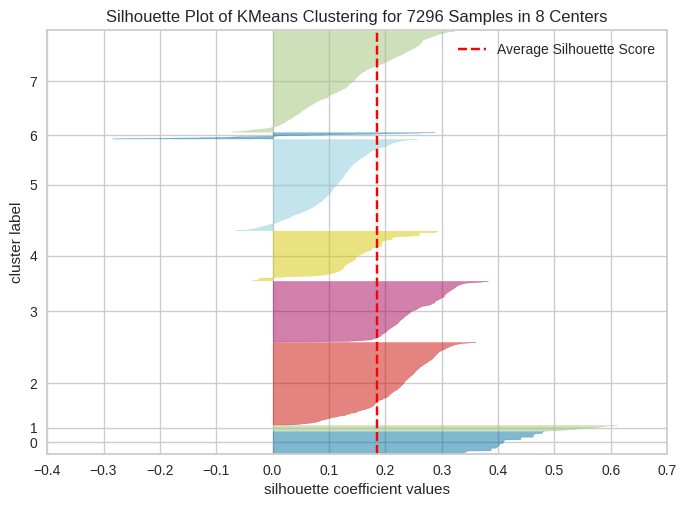

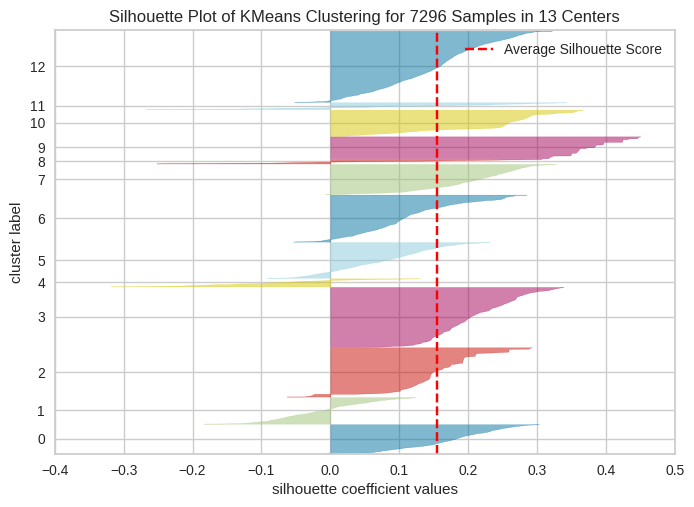

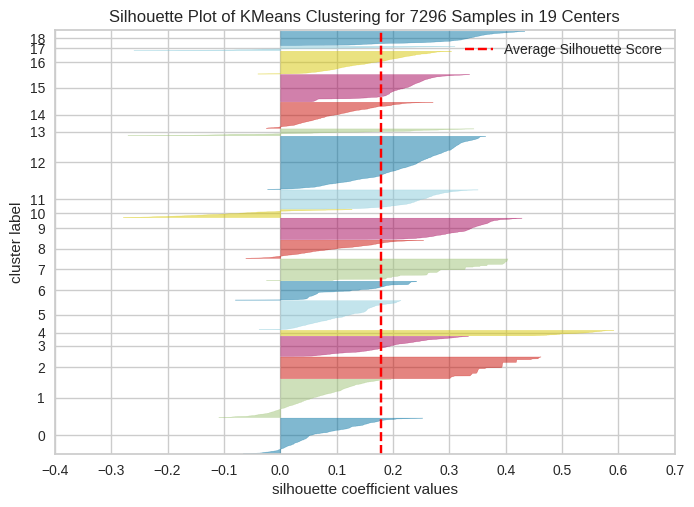

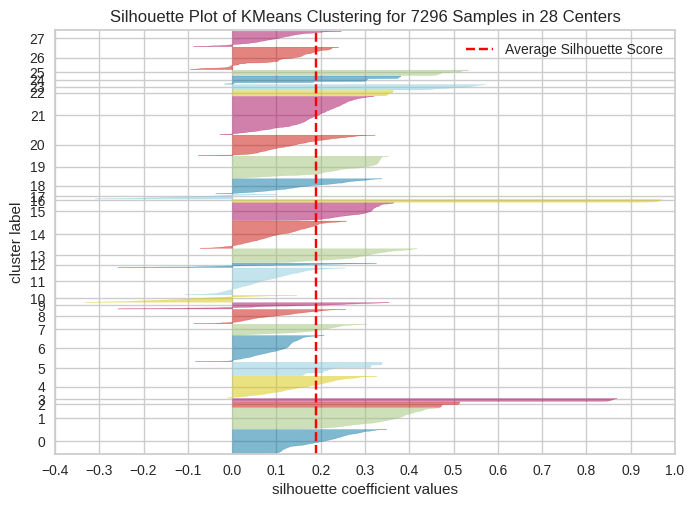

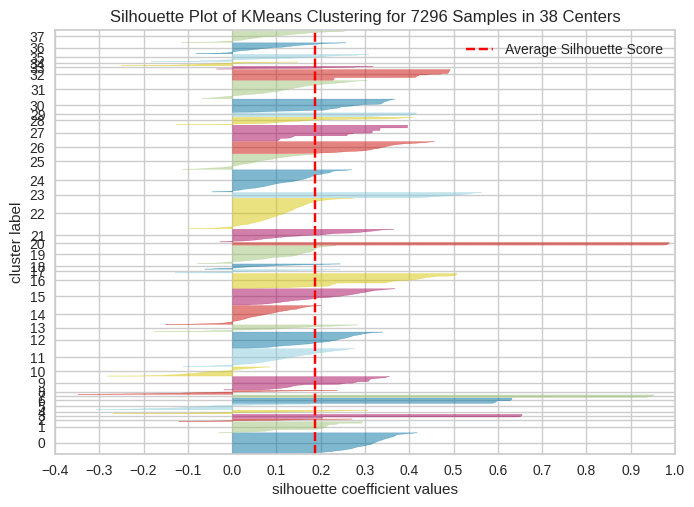

In [53]:
for k in k_s:
    initial_centroids = X_train[np.random.choice(X_train.shape[0], k, replace=False)]
    k_labels,centroids=kmeans(k,initial_centroids)
    kmeans_model = KMeans(n_clusters=k, init=centroids, n_init=1)
    visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick')
    visualizer.fit(X_train)
    visualizer.show()

k = 19 is the best k Because it the closest to the number of labels of ground truth
<br>
In silhouette charts:
<br>


## Evaluation

### Classifying Test Data By K-means centroids Using Nearest Centroid Classifier

In [109]:
def nearest_centroid(x,centroids):
    min_dist=float('inf')
    cluster=0
    for j in range (len(centroids)):
        dist=eucldiean_dist(x,centroids[j])
        if dist<min_dist:
            min_dist=dist
            cluster=j+1
    return cluster
def classify_test_set(k,train_set,test_set):
    _,centroids=BestRandomStart(train_set,k)
    y_pred=[]
    for x in test_set:
        y_pred.append(nearest_centroid(x,centroids))
    return y_pred 

### Mapping points in each cluster to its ground truth

In [91]:
def mapping(k,y_pred,y_actual):
    clusters=[[] for _ in range(k)]
    for i in range(len(y_pred)):
        clusters[y_pred[i]-1].append((int) (y_actual[i]))
    return clusters

## Precision measure

In [50]:
def calculate_precision(clusters,length):
    precisions=[]
    for cluster in clusters:
        if len(cluster)==0:
            precisions.append(0)
            continue
        counts=np.bincount(cluster)
        precisions.append(max(counts)/len(cluster))
    precision_score=0
    for i in range(len(clusters)):
        if len(clusters[i])==0:
            continue
        precision_score+=((len(clusters[i]))/length)*precisions[i]
    return precision_score,precisions



## Recall measure

In [54]:
def calculate_recall(clusters,k,test_labels):
    recalls=[]
    for cluster in clusters:
        if len(cluster)==0:
            recalls.append(0)
            continue
        counts=np.bincount(cluster)
        recalls.append(max(counts)/max(np.bincount(test_labels)))
    recall_score=0
    for i in range(k):
        if len(clusters[i])==0:
            continue
        recall_score+=((len(clusters[i]))/len(test_labels))*recalls[i]
    return recall_score,recalls

## F measure

In [46]:
def calculate_f1_score(precisions,recalls):
    f1_scores=[]
    for i in range(len(precisions)):
        if precisions[i]==0 and recalls[i]==0:
            f1_scores.append(0)
        else:
            f1_scores.append(2*(precisions[i]*recalls[i])/(precisions[i]+recalls[i]))
    return sum(f1_scores)/len(f1_scores)

## Conditional Entropy

In [82]:
def calculate_conditional_entropy(clusters,test_labels):
    total_conditional_entropy=0
    for cluster in clusters:
        if len(cluster)==0:
            continue
        conditional_entropy=0
        for i in range(1,19):
            count=cluster.count(i)
            if count!=0:
                conditional_entropy-=(count/len(cluster))*m.log2(count/len(cluster))
        total_conditional_entropy+=((len(cluster))/len(test_labels))*conditional_entropy
    return total_conditional_entropy



In [92]:
def Test_Evaluation(train_set,test_set,actual_labels):
    actual_labels=actual_labels.astype(int)
    k_s=[8,13,19,28,38]
    precision_scores=[]
    recall_scores=[]
    f1_scores=[]
    conditional_entropies=[]
    for k in k_s:
        y_pred=classify_test_set(k,train_set,test_set)
        clusters=mapping(k,y_pred,actual_labels)
        precision_score,precisions=calculate_precision(clusters,len(actual_labels))
        recall_score,recalls=calculate_recall(clusters,k,actual_labels)
        f1_score=calculate_f1_score(precisions,recalls)
        conditional_entropy=calculate_conditional_entropy(clusters,actual_labels)
        precision_scores.append(precision_score)
        recall_scores.append(recall_score)
        f1_scores.append(f1_score)
        conditional_entropies.append(conditional_entropy)
    return precision_scores,recall_scores,f1_scores,conditional_entropies  
precision_scores_mean,recall_scores_mean,f1_scores_mean,conditional_entropies_mean=Test_Evaluation(X_train,X_test,y_test)
precision_scores_flatten,recall_scores_flatten,f1_scores_flatten,conditional_entropies_flatten=Test_Evaluation(X_train_flatten,X_test_flatten,y_test_flatten) 
print("Mean Method")   
for i in range(len(k_s)):
    print("K=",k_s[i])
    print("Precision Score:",precision_scores_mean[i])
    print("Recall Score:",recall_scores_mean[i])
    print("F1 Score:",f1_scores_mean[i])
    print("Conditional Entropy:",conditional_entropies_mean[i])
    print(" ")     
print("_"*50)
print("Flatten Method")
for i in range(len(k_s)):
    print("K=",k_s[i])
    print("Precision Score:",precision_scores_flatten[i])
    print("Recall Score:",recall_scores_flatten[i])
    print("F1 Score:",f1_scores_flatten[i])
    print("Conditional Entropy:",conditional_entropies_flatten[i])
    print(" ")


Mean Method
K= 8
Precision Score: 0.3393640350877193
Recall Score: 0.9732730263157894
F1 Score: 0.5001751221074165
Conditional Entropy: 2.055401630831439
 
K= 13
Precision Score: 0.47313596491228066
Recall Score: 0.8424936038011696
F1 Score: 0.5668973335645159
Conditional Entropy: 1.6503535815820012
 
K= 19
Precision Score: 0.5723684210526316
Recall Score: 0.7266196089181286
F1 Score: 0.5482175139797572
Conditional Entropy: 1.309599181608475
 
K= 28
Precision Score: 0.6332236842105263
Recall Score: 0.5968281706871345
F1 Score: 0.47514404079205297
Conditional Entropy: 1.0672354174935963
 
K= 38
Precision Score: 0.7171052631578948
Recall Score: 0.45388454861111105
F1 Score: 0.4553751633611083
Conditional Entropy: 0.8771662291015372
 
__________________________________________________
Flatten Method
K= 8
Precision Score: 0.381578947368421
Recall Score: 0.9409950657894736
F1 Score: 0.5990679473862414
Conditional Entropy: 1.9636919525334213
 
K= 13
Precision Score: 0.5060307017543859
Recall

In [95]:
def Train_Evaluation(train_set,actual_labels):
    k_s=[8,13,19,28,38]
    actual_labels=actual_labels.astype(int)
    precision_scores=[]
    recall_scores=[]
    f1_scores=[]
    conditional_entropies=[]
    for k in k_s:
        k_labels,_=BestRandomStart(train_set,k)
        clusters=mapping(k,k_labels,actual_labels)
        precision_score,precisions=calculate_precision(clusters,len(actual_labels))
        recall_score,recalls=calculate_recall(clusters,k,actual_labels)
        f1_score=calculate_f1_score(precisions,recalls)
        conditional_entropy=calculate_conditional_entropy(clusters,actual_labels)
        precision_scores.append(precision_score)
        recall_scores.append(recall_score)
        f1_scores.append(f1_score)
        conditional_entropies.append(conditional_entropy)
    return precision_scores,recall_scores,f1_scores,conditional_entropies
precision_scores_mean_train,recall_scores_mean_train,f1_scores_mean_train,conditional_entropies_mean_train=Train_Evaluation(X_train,y_train)
precision_scores_flatten_train,recall_scores_flatten_train,f1_scores_flatten_train,conditional_entropies_flatten_train=Train_Evaluation(X_train_flatten,y_train_flatten)
print("Mean Method")        
for i in range(len(k_s)):
    print("K=",k_s[i])
    print("Precision Score:",precision_scores_mean_train[i])
    print("Recall Score:",recall_scores_mean_train[i])
    print("F1 Score:",f1_scores_mean_train[i])
    print("Conditional Entropy:",conditional_entropies_mean_train[i])
    print(" ")
print("_"*50)
print("Flatten Method")
for i in range(len(k_s)):
    print("K=",k_s[i])
    print("Precision Score:",precision_scores_flatten_train[i])
    print("Recall Score:",recall_scores_flatten_train[i])
    print("F1 Score:",f1_scores_flatten_train[i])
    print("Conditional Entropy:",conditional_entropies_flatten_train[i])
    print(" ")
      

Mean Method
K= 8
Precision Score: 0.3404605263157895
Recall Score: 0.9734586302997076
F1 Score: 0.5046093991054084
Conditional Entropy: 2.0563123853194094
 
K= 13
Precision Score: 0.4845120614035087
Recall Score: 0.8943513569078948
F1 Score: 0.5865311817572945
Conditional Entropy: 1.6687075582093747
 
K= 19
Precision Score: 0.6081414473684211
Recall Score: 0.7736609386421782
F1 Score: 0.5758473621112913
Conditional Entropy: 1.2481003025093833
 
K= 28
Precision Score: 0.6540570175438595
Recall Score: 0.5320741530747441
F1 Score: 0.5073969015058012
Conditional Entropy: 1.105728602095073
 
K= 38
Precision Score: 0.6688596491228072
Recall Score: 0.4306529976471127
F1 Score: 0.4254160967343497
Conditional Entropy: 1.0441930780093236
 
__________________________________________________
Flatten Method
K= 8
Precision Score: 0.39610745614035087
Recall Score: 0.9437320106907895
F1 Score: 0.6472984438096988
Conditional Entropy: 1.9822598589817144
 
K= 13
Precision Score: 0.4984923245614035
Recall

## Analysis

### Comparison Between number of clusters

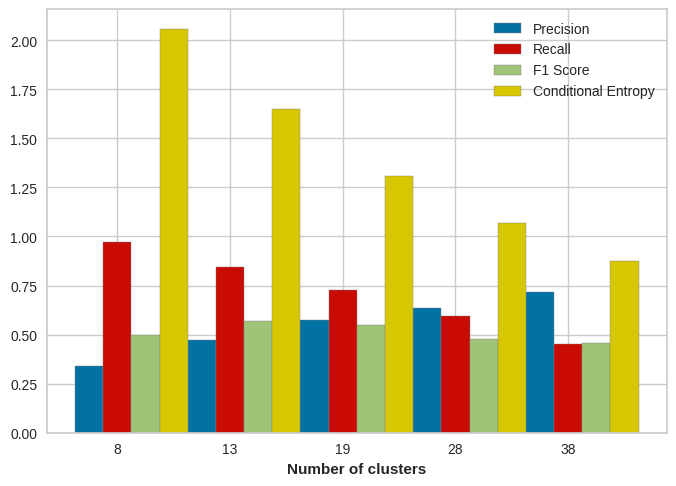

In [103]:
# bar chart for precision, recall, f1 score and conditional entropy for each k
# for mean method
barWidth = 0.25
bars1 = precision_scores_mean
bars2 = recall_scores_mean
bars3 = f1_scores_mean
bars4 = conditional_entropies_mean
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='grey', label='F1 Score')
plt.bar(r4, bars4, color='y', width=barWidth, edgecolor='grey', label='Conditional Entropy')
plt.xlabel('Number of clusters', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], k_s)
plt.legend()
plt.show()


The Precision increases as number of clusters increases <br>
The Recall & Conditional Entropy decreases as number of clusters increases <br>
The F-measure doesn't have a pattern

### Comparison Between number of clusters with respect to Train Data

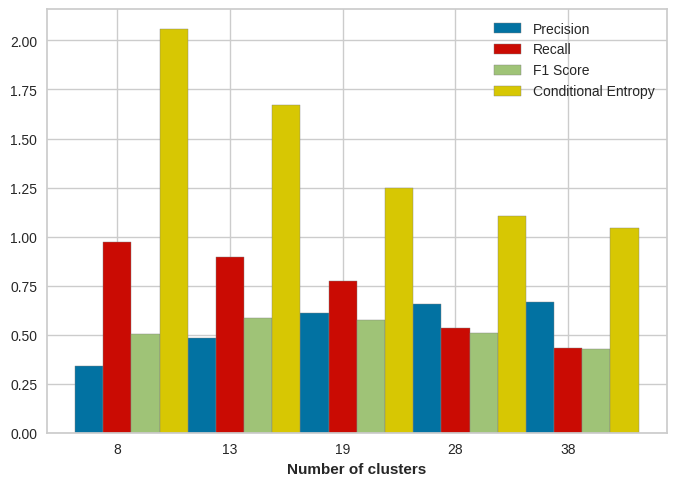

In [104]:
# bar chart for precision, recall, f1 score and conditional entropy for each k
# for mean method
barWidth = 0.25
bars1 = precision_scores_mean_train
bars2 = recall_scores_mean_train
bars3 = f1_scores_mean_train
bars4 = conditional_entropies_mean_train
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='grey', label='F1 Score')
plt.bar(r4, bars4, color='y', width=barWidth, edgecolor='grey', label='Conditional Entropy')
plt.xlabel('Number of clusters', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], k_s)
plt.legend()
plt.show()


The same observation as Test Data

## Comparison Between Two Methods of Data Generation With respect to Following Metrics:

### Precision

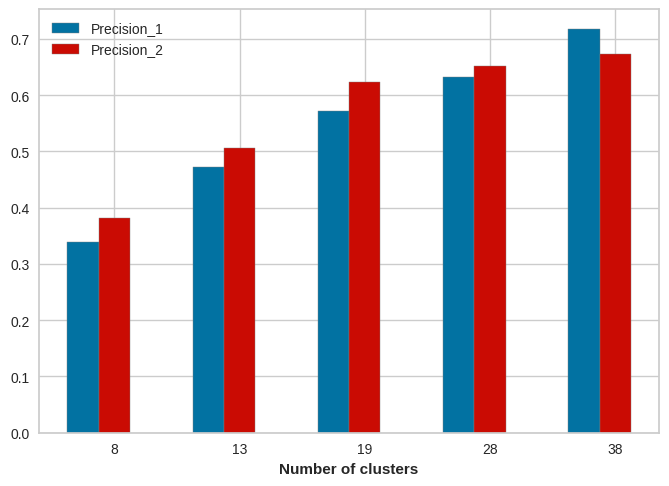

In [105]:
barWidth = 0.25
bars1 = precision_scores_mean
bars2 = precision_scores_flatten
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Precision with Mean Method')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='Precision with Flatten Method')
plt.xlabel('Number of clusters', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], k_s)
plt.legend()
plt.show()

### Recall

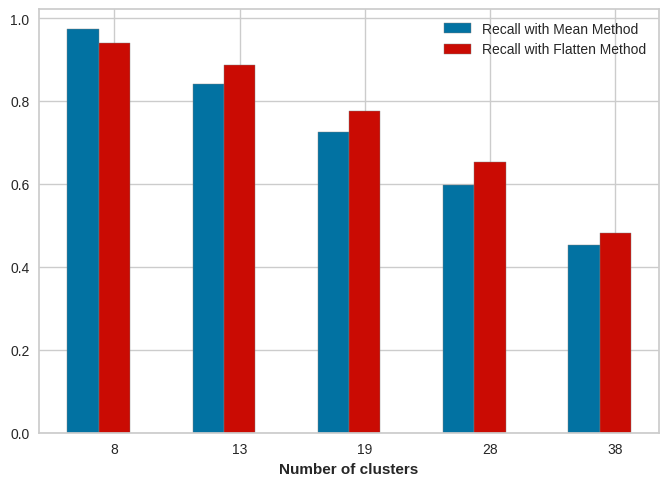

In [106]:
barWidth = 0.25
bars1 = recall_scores_mean
bars2 = recall_scores_flatten
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Recall with Mean Method')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='Recall with Flatten Method')
plt.xlabel('Number of clusters', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], k_s)
plt.legend()
plt.show()

### F-measure

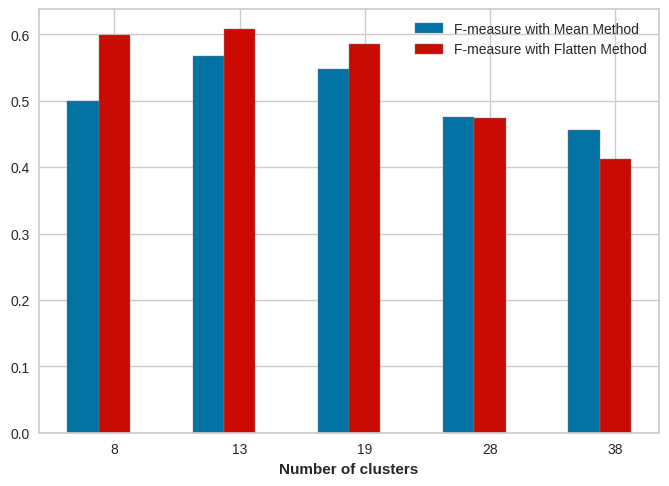

In [107]:
barWidth = 0.25
bars1 = f1_scores_mean
bars2 = f1_scores_flatten
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='F-measure with Mean Method')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='F-measure with Flatten Method')
plt.xlabel('Number of clusters', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], k_s)
plt.legend()
plt.show()

### Conditional Entropy

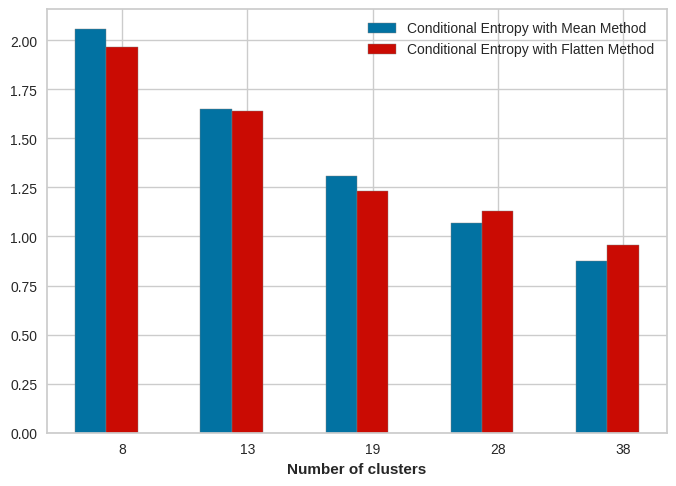

In [108]:
barWidth = 0.25
bars1 = conditional_entropies_mean
bars2 = conditional_entropies_flatten
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Conditional Entropy with Mean Method')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='Conditional Entropy with Flatten Method')
plt.xlabel('Number of clusters', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], k_s)
plt.legend()
plt.show()